# Segmentation Surfaces

## Introduction

In this exercise you will work with surfaces in segmented volume. Using the marching cubes algorithm, you will obtain mesh structures that describe the surfaces of different tissue types in the brain.

The data for this exercise is a volume of an MR brain scan, which is already segmented into nine different tissue types. You will extract a subvolume which contain a couple of gyri and sulci, which are cortical structures in the gray matter.

The goal is to estimate the thickness of the gray matter structure. Gray matter covers the white matter to the inside and is surrounded by CSF (cerebrospinal fluid). Your approach will be to extract the white matter surface, move the surface elements iteratively in its normal direction to the outside until it hits CSF. Tracking the number of steps taken lets you approximate the gray matter thickness.

### Input data and code hints
In your MIA environment (env_mia), you need to install the following package:

    conda install scikit-image

Import Python libraries:

> ***Hint:***
> - You may want to choose the matplotlib tk engine for some 3D plot, since they will be interactive figures, which you might want to enlarge in a separate window

In [1]:
import nibabel as nib
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
import skimage
from skimage import measure, morphology
from scipy.ndimage import map_coordinates
%matplotlib inline

### Load data and extract meta data

The whole volume is shown in the figure below. For all following tasks, use **only the subvolume!**

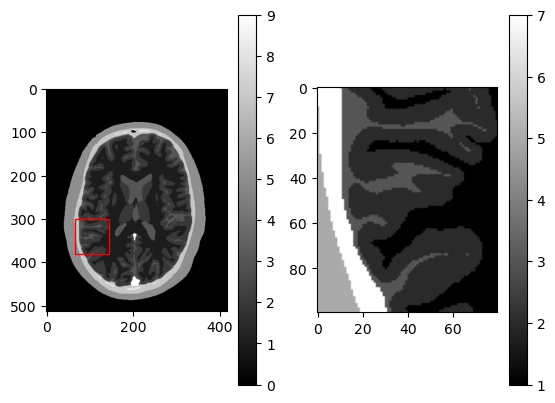

In [2]:
img = nib.load("tissue_labeling_upsampled.nii")
img_data = np.squeeze(img.get_fdata())


affine = img.affine
affine_inv = np.linalg.inv(affine)

vox_dimensions = img.header.get_zooms()

# Cut out subvolume
subvolume = img_data[300:400, 340:360,65:145]
rect_subvolume = patches.Rectangle((65, 300), 80, 80, linewidth=1, edgecolor='r', facecolor='none')

fig, ax = plt.subplots(1,2)
img = ax[0].imshow(img_data[:,340,:], cmap='gray')
sub = ax[0].add_patch(rect_subvolume)
subv = ax[1].imshow(subvolume[:,0,:], cmap='gray')
fig.colorbar(img, ax=ax[0])
fig.colorbar(subv, ax=ax[1])
plt.show()

## Task 1: Create binary segmentations

For surface creation, you need binary segmentation of the tissue of which you want to create a surface. The three tissue types of interest for this exercise are White Matter (WM), Gray Matter (GM) and CSF (Cerebrospinal Fluid). Create a mask based on the initial segmentation labels for those three tissues and create three binary volume for each tissue. 

The tissue labels in the original segmented volume are:
- WM: 1
- GM: 2
- CSF: 3

> ***Hints:***
> - Morphological operations help with filling little "holes" in segmented areas. To obtain smoother thickness estimates, you can run a morphological dilation on the target tissue CSF as follows:
>       ```csf_dilated = morphology.binary_dilation(csf)```


## Task 2: Marching Cubes

a) Use the marching cubes algorithm to create mesh structures for all three surfaces using 
    
``` nodes, faces, _, _ = measure.marching_cubes_lewiner(binary_volume, step_size=1, level=0.5) ```.

You only need the nodes and the triangle faces, so you can ignore the last two output parameters. The documentation can be found here: https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.marching_cubes. Note that "node" and "vertex" are used interchangeably and refer to the same structure in this exercise.

b) Plot the surfaces. You can use the code snippet provided below. It assumes you calculated the nodes for WM, GM and CSF (```nodes_wm, nodes_gm, nodes_csf```) and the faces for WM, GM and CSF (```faces_wm, faces_gm, faces_csf```) before.

> ***Hints:***
> - ``nodes``: returns coordinates for each node in the surface
> - ``faces``: return three indices for nodes in ```nodes``` for each triangle
> 
> - set ```step_size = 1```
> - set ```level = 0.5```


In [3]:
# PLOT SURFACES
%matplotlib tk

fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(131, projection='3d')

mesh1 = Poly3DCollection(nodes_wm[faces_wm])
mesh1.set_edgecolor('k')
mesh1.set(lw=0.1)
ax1.add_collection3d(mesh1)

ax1.set_xlabel("x-axis")
ax1.set_ylabel("y-axis")
ax1.set_zlabel("z-axis")
ax1.set_xlim(0, subvolume.shape[0])
ax1.set_ylim(0, subvolume.shape[1])
ax1.set_zlim(0, subvolume.shape[2])
ax1.set_title('WM')

ax2 = fig.add_subplot(132, projection='3d')

mesh2 = Poly3DCollection(nodes_gm[faces_gm])
mesh2.set_edgecolor('k')
mesh2.set(lw=0.1)
ax2.add_collection3d(mesh2)

ax2.set_xlabel("x-axis")
ax2.set_ylabel("y-axis")
ax2.set_zlabel("z-axis")
ax2.set_xlim(0, subvolume.shape[0])
ax2.set_ylim(0, subvolume.shape[1])
ax2.set_zlim(0, subvolume.shape[2])
ax2.set_title('GM')

ax3 = fig.add_subplot(133, projection='3d')

mesh3 = Poly3DCollection(nodes_csf[faces_csf])
mesh3.set_edgecolor('k')
mesh3.set(lw=0.1)
ax3.add_collection3d(mesh3)

ax3.set_xlabel("x-axis")
ax3.set_ylabel("y-axis")
ax3.set_zlabel("z-axis")
ax3.set_xlim(0, subvolume.shape[0])
ax3.set_ylim(0, subvolume.shape[1])
ax3.set_zlim(0, subvolume.shape[2])
ax3.set_title('CSF')

plt.tight_layout()
plt.show()

NameError: name 'nodes_wm' is not defined

## Task 2: Calculate the node normals

In order to move the WM surface elements towards CSF, you need to define the normal direction at each WM node, that points to the outside of the surface.

For each WM triangle node, the normal can be obtained by calculating the cross-product of the two vectors that span the triangle from the node. You can calculate the cross-product for each pair of connected edges and average the result. That will smooth the normals and improves the deformation of the surface.

When you calculated the WM normals, use the code snippet below to perform the smoothing. Additional to ``nodes_wm`` and ``faces_wm``, it assumes you calculated ``normals_wm``.

> ***Hints:***
> - the three coordinates for the three nodes in one triangle can be accessed as follows
>       ```nodes_wm[faces_wm[0,:]]```
>   
>    consequently, the first node's coordinates of all triangles can be accessed by
>       ```nodes_wm[faces_wm[:,0]]```
> 
>- use np.cross(v2, v1, axis=1) to calculate the right-handed cross-product, where
>
>   ```v1``` is the vector between the first and second node for all triangles
>
>   ```v2``` is the vector between the first and third node for all triangles
>
> - You can add the following line to your 3D surface plot to display the calculated normals at each node. Make sure, the normals point to the outside, so that you move in the correct direction.
>       ```ax1.quiver(nodes_wm[:,0], nodes_wm[:,1], nodes_wm[:,2], normals_wm[:,0], normals_wm[:,1], normals_wm[:,2])```


In [45]:
# SMOOTHING
nd = np.zeros((len(nodes_wm), 3))
for s in range(1):
    for i in range(3):
        nd[:, i] = \
            np.bincount(faces_wm.reshape(-1),
                        np.repeat(normals_wm[:, i], 3),
                        len(nodes_wm))

    normals_wm_smooth = np.sum(nd[faces_wm], axis=1)
    normals_wm_smooth /= np.linalg.norm(normals_wm, axis=1)[:, None]

    nodes_pos = np.unique(faces_wm)
    nd[nodes_pos] = nd[nodes_pos] / np.linalg.norm(nd[nodes_pos], axis=1)[:, None]

    normals_wm = nd

## Task 3: Transform the volume coordinates into world space

You will move the surface nodes in world space to track the distance to CSF (thickness of GM) in $mm$. Map the WM nodes and normals into world space using the affine.

> ***Hints:***
> - like in the previous exercises, you can create a coordinate grid $V$ with components $v1, v2, v3$ using ```np.meshgrid()```
> - map the coordinates using the relation
> $$
> \mathbf{X} = \mathbf{A} \mathbf{v} + \mathbf{t}
> $$ 
>    where $\mathbf{A}$ and $\mathbf{t}$ are the rotation and translation components of the affine $\mathbf{M}$.
>
> - the affine $\mathbf{M}$ is given above

## Task 4: Expand WM surface

Iteratively move every node on the WM surface by a step size of e.g. $0.01 mm$ in the direction of each nodes normal.

Define the following break criteria for individual nodes when you should or should not estimate the GM thickness:
- the node reached CSF
- the node reached the volumes boundary
- the node reached WM

If, and only if, the node reached CSF, save the thickness estimate for that node.

You can set your movement radius to 15 $mm$ to define a stopping criterion for the algorithm.

The last two criteria represent cases where the normal direction led to a position where it is not meaningful to estimate a gray matter thickness. Discuss why! (task 7)

> ***Hints:***
> - To check if the node reached CSF or WM, perform a mapping from the new node position to the segmentation (voxel) space of the original volume using the inverse affine. Be sure to use nearest neighbour interpolation (order=0) in the ``map_coordinates()`` function, because you want the integer label. 
>
>- To check if the volume boundary is reached, obtain the minimum and maximum value in world space of the volume for each x-, y- and z-coordinate. In each step, check if the minimum or maximum is exceeded.

## Task 5: Histogram of GM thickness estimates

Show your thickness estimates for all nodes in a histogram plot using 

        plt.hist(x, bins, range)

Clip your data above zero using the ``range`` argument to exclude thickness estimates from nodes that did not hit CSF.

### Task 6: Visualize Results

Plot your thickness estimates from nodes that hits CSF in 3D or 2D. Be sure to be consistent, in what space you are plotting, world or voxel. The code snippet below use the voxel space. The coordinates of the moved WM nodes need therefore to be transformed back to voxel space with the inverse affine.

Below are two code snippets that visualize the results. It shows the final location of the moved WM nodes on the gray matter surface, with the color indicating the thickness estimate. On the right side is a plot of the gray matter surface. That serves as a reference the moved points should lie on that surface.

The 3D plot shows all thickness estimates, but might be hard to evaluate. The 2D option only looks at specific slices, here you might want to look at a variety of slices to analyze the results.

> ***Hints:***
>
> The code snippet assumes you have defined the following variables:
> - ``target_hit`` are the indices of nodes that reached CSF
> - ``nodes_gm`` are the nodes of the GM surfaces, obtained from the marching cubes algorithm
> - ``faces_gm`` are the faces of the GM surface, obtained from the marching cubes algorithm
> - ``wm_moved`` is the moved WM nodes, mapped back into segmentation (voxel) space
> - ``thickness`` are the thickness estimates
> - ``vox_dimensions`` is defined above, obtained from the affine of the volume
> - ``gray_matter`` is the binary volume from task 1

In [49]:
%matplotlib tk
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(121, projection='3d')

target_hits = wm_moved[target_hit]

sc = ax1.scatter(target_hits[:,0], target_hits[:,1], target_hits[:,2], c=thickness[target_hit])

ax1.set_xlabel("x-axis")
ax1.set_ylabel("y-axis")
ax1.set_zlabel("z-axis")
ax1.set_xlim(0, subvolume.shape[0])
ax1.set_ylim(0, subvolume.shape[1])
ax1.set_zlim(0, subvolume.shape[2])
ax1.set_title('Tickness estimates at target points [mm]')

ax2 = fig.add_subplot(122, projection='3d')

mesh2 = Poly3DCollection(nodes_gm[faces_gm])
mesh2.set_edgecolor('k')
ax2.add_collection3d(mesh2)

ax2.set_xlabel("x-axis")
ax2.set_ylabel("y-axis")
ax2.set_zlabel("z-axis")
ax2.set_xlim(0, subvolume.shape[0])
ax2.set_ylim(0, subvolume.shape[1])
ax2.set_zlim(0, subvolume.shape[2])
ax2.set_title('GM')

fig.colorbar(sc, ax = ax1)

plt.tight_layout()
plt.show()

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)

slct_y_plane = 10
ax1.imshow(gray_matter[:,slct_y_plane,:], cmap='gray')

target_hits = wm_moved[target_hit]
target_hits_plane_idx = (target_hits[:,1] > slct_y_plane-.5*vox_dimensions[1]) * (target_hits[:,1] < slct_y_plane+.5*vox_dimensions[1])
target_hits_plane = target_hits[target_hits_plane_idx,:]
sc = ax1.scatter(target_hits_plane[:,2], target_hits_plane[:,0], c=thickness[target_hit][target_hits_plane_idx])
fig.colorbar(sc, ax=ax1)
fig.suptitle('target hits with thickness estimate [mm] in one plane')
plt.tight_layout()
plt.show()

### Task 7: Discussion
Discuss if your thickness estimates are reasonable.
- What problems might occur in this approach?
- Where could outliers comes from?
- What is the problem when WM is hit by a moved node?
- Is there a scenario where it makes sense to estimate the GM thickness when a node hits WM again?
- Why is smoothing of normals reasonable?